c:\Users\전승윤\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")



🚀 Noise Robustness Experiment Started...
    > Training relu...
    > Training gelu...
    > Training silu...
    > Training oscillatory...


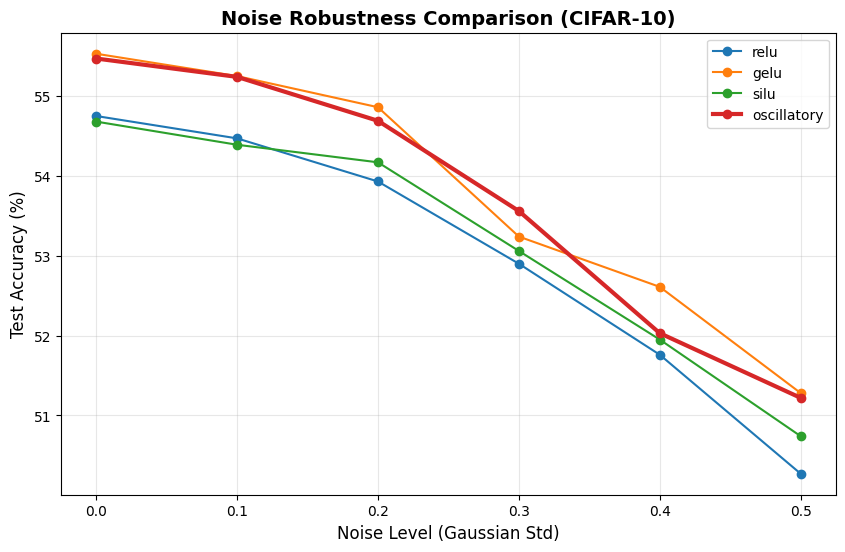

In [1]:
# ---------------------------------------------------------
# [1] 라이브러리 임포트 (Import Libraries)
# ---------------------------------------------------------
import torch  # 파이토치: 딥러닝 모델 설계 및 텐서 연산을 위한 핵심 엔진입니다.
import torch.nn as nn  # 신경망 모듈: 레이어, 손실 함수 등 구조 정의에 사용됩니다.
import torch.optim as optim  # 최적화 모듈: 가중치를 업데이트하는 알고리즘(Adam 등)을 제공합니다.
from torchvision import datasets, transforms  # 데이터셋: CIFAR-10 등 표준 데이터를 불러오고 전처리합니다.
from torch.utils.data import DataLoader  # 데이터 로더: 데이터를 배치(Batch) 단위로 쪼개어 모델에 주입합니다.
import matplotlib.pyplot as plt  # 시각화: 실험 결과를 그래프로 시각화합니다.
import numpy as np  # 넘파이: 수치 해석 및 노이즈 생성 등을 위한 도구입니다.
import os  # OS: 시스템 경로 및 파일 존재 여부를 확인합니다.

# ---------------------------------------------------------
# [2] 활성화 함수 정의 (Custom Activation Functions)
# ---------------------------------------------------------

# (1) 제안 모델: Oscillatory Soft Gate
class OscillatorySoftGate(nn.Module):
    """ [Proposed] 제안하는 위상 적응형 활성화 함수입니다. """
    def __init__(self, a=1.0, b=1.0):
        super(OscillatorySoftGate, self).__init__()
        # 파라미터 a(진폭)와 b(주파수)를 학습 가능한 변수(nn.Parameter)로 등록합니다.
        self.a = nn.Parameter(torch.tensor(a))
        self.b = nn.Parameter(torch.tensor(b))

    def forward(self, x):
        # 수식: x * sigmoid(x + a * sin(b * x))
        # 게이트 내부에 주기적 성분을 도입하여 국소적 특징(Local features) 포착력을 높입니다.
        return x * torch.sigmoid(x + self.a * torch.sin(self.b * x))

# ---------------------------------------------------------
# [3] 범용 DNN 아키텍처 (Universal Architecture)
# ---------------------------------------------------------
class UniversalNet(nn.Module):
    """ 다양한 데이터셋에 유연하게 대응하는 다층 퍼셉트론(MLP) 구조입니다. """
    def __init__(self, activation_name, input_dim, num_classes, num_layers=5, hidden_dim=256):
        super(UniversalNet, self).__init__()
        
        layers = [] # 신경망 층을 순차적으로 담을 리스트입니다.
        
        # [입력층] 입력 차원(CIFAR-10의 경우 3072)을 은닉층 차원으로 변환합니다.
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.BatchNorm1d(hidden_dim)) # 학습 가속화 및 안정화를 위한 배치 정규화입니다.
        
        # 활성화 함수 선택 함수
        def get_activation(name):
            if name == 'relu': return nn.ReLU() # 표준 ReLU
            elif name == 'gelu': return nn.GELU() # 최신 딥러닝 표준인 GELU
            elif name == 'silu': return nn.SiLU() # Swish 함수로 알려진 SiLU
            elif name == 'oscillatory': return OscillatorySoftGate() # 본 연구의 제안 함수
            return nn.ReLU()

        # [은닉층 반복 생성] num_layers 만큼 깊은 망을 구성합니다.
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim)) # 선형 결합
            layers.append(nn.BatchNorm1d(hidden_dim))        # 정규화
            layers.append(get_activation(activation_name))   # 비선형 활성화 함수
            layers.append(nn.Dropout(0.2))                   # 과적합 방지를 위한 드롭아웃입니다.

        self.features = nn.Sequential(*layers) # 레이어들을 하나의 모듈로 묶습니다.
        self.classifier = nn.Linear(hidden_dim, num_classes) # 최종 분류를 위한 출력층입니다.

    def forward(self, x):
        x = x.view(x.size(0), -1) # 3D 이미지를 1D 벡터로 평탄화(Flatten)합니다.
        x = self.features(x)      # 특징 추출부를 통과합니다.
        return self.classifier(x) # 최종 클래스 확률 로짓을 반환합니다.

# ---------------------------------------------------------
# [4] 데이터셋 설정 함수 (Dataset Loader)
# ---------------------------------------------------------
def get_dataset_config(dataset_name, batch_size=128):
    """ CIFAR-10 데이터를 로드하고 전처리(Resize, Normalize)를 수행합니다. """
    common_transform = transforms.Compose([
        transforms.Resize((32, 32)),      # 이미지 크기를 32x32로 통일합니다.
        transforms.ToTensor(),            # 이미지를 0~1 사이의 텐서로 변환합니다.
        transforms.Normalize((0.5,), (0.5,)) # 데이터를 -1~1 사이로 정규화합니다.
    ])
    
    # CIFAR-10 학습/테스트 데이터 다운로드 및 로드
    train_d = datasets.CIFAR10('./data', train=True, download=True, transform=common_transform)
    test_d = datasets.CIFAR10('./data', train=False, download=True, transform=common_transform)
    
    # 3(RGB) * 32 * 32 = 3072 차원이며, 클래스는 10개입니다.
    input_dim = 3 * 32 * 32; num_classes = 10
    
    train_loader = DataLoader(train_d, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_d, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader, input_dim, num_classes

# ---------------------------------------------------------
# [5] 노이즈 강건성 평가 함수 (Robustness Analysis)
# ---------------------------------------------------------
def test_robustness_analysis(model_name, train_loader, test_loader, in_dim, n_classes, device):
    """ 모델을 학습시킨 후 가우시안 노이즈 강도별 정확도를 측정합니다. """
    print(f"    > Training {model_name}...")
    model = UniversalNet(model_name, in_dim, n_classes).to(device) # 모델 생성 및 GPU 할당
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 옵티마이저 설정
    criterion = nn.CrossEntropyLoss() # 손실 함수 설정
    
    # [학습] 강건성 비교를 위한 기초 학습 진행 (10 에포크)
    for epoch in range(10):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # [노이즈 단계별 평가] 0.0(원본)부터 0.5(심한 노이즈)까지 6단계로 평가합니다.
    noise_levels = np.linspace(0, 0.5, 6)
    robustness_accs = []
    
    model.eval()
    for std in noise_levels:
        correct = 0; total = 0
        with torch.no_grad(): # 평가 단계에서는 기울기를 계산하지 않습니다.
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                
                # 가우시안 노이즈(Gaussian Noise)를 데이터에 직접 주입합니다.
                noisy_data = torch.clamp(data + torch.randn_like(data) * std, -1, 1)
                
                output = model(noisy_data)
                correct += output.argmax(1).eq(target).sum().item() # 정답 수 카운트
                total += target.size(0)
        
        robustness_accs.append(100. * correct / total) # 각 단계 정확도 저장
        
    return noise_levels, robustness_accs

# ---------------------------------------------------------
# [6] 메인 실행부 (Execution)
# ---------------------------------------------------------
if __name__ == "__main__":
    # GPU(CUDA) 가용 여부를 체크합니다.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 데이터셋 구성 로드
    train_loader, test_loader, in_dim, n_classes = get_dataset_config('CIFAR10')
    
    # 비교 실험 대상 활성화 함수 목록입니다.
    comparison_targets = ['relu', 'gelu', 'silu', 'oscillatory']
    results_map = {}

    print("\n🚀 Noise Robustness Experiment Started...")
    for act in comparison_targets:
        # 각 활성화 함수별로 학습 및 노이즈 테스트 수행
        levels, accs = test_robustness_analysis(act, train_loader, test_loader, in_dim, n_classes, device)
        results_map[act] = accs

    # [그래프 시각화] 연구 논문 스타일로 결과를 출력합니다.
    plt.figure(figsize=(10, 6))
    for act, accs in results_map.items():
        # 제안 모델(oscillatory)은 굵은 선으로 강조하여 시각적 차별성을 둡니다.
        linewidth = 3 if act == 'oscillatory' else 1.5
        plt.plot(levels, accs, label=act, linewidth=linewidth, marker='o')

    plt.title("Noise Robustness Comparison (CIFAR-10)", fontsize=14, weight='bold')
    plt.xlabel("Noise Level (Gaussian Std)", fontsize=12)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show() # 최종 그래프 출력